In [ ]:
!pip install numba

CPU grayscale conversion time: 0.6022 seconds
GPU grayscale conversion time: 0.4548 seconds


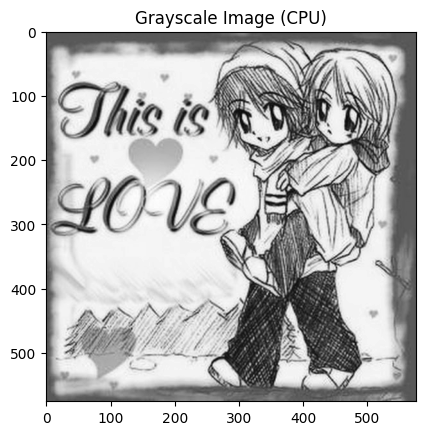

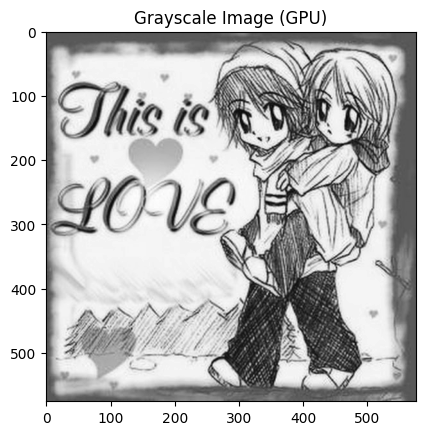

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, njit
import time

def load_image(path):
    return plt.imread(path).astype(np.float32)

def flatten_image(image):
    return image.reshape(-1, 3)

@njit
def to_grayscale_cpu(pixels):
    pixel_count = len(pixels)
    gray_pixels = np.empty(pixel_count)
    for i in range(pixel_count):
        r, g, b = pixels[i]
        gray_pixels[i] = 0.299 * r + 0.587 * g + 0.114 * b
    return gray_pixels

@cuda.jit
def to_grayscale_gpu(pixels, gray_pixels):
    idx = cuda.grid(1)
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

def perform_gpu_conversion(pixels, blocks_per_grid, threads_per_block):
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array(len(pixels), dtype=np.float32)
    to_grayscale_gpu[blocks_per_grid, threads_per_block](pixels_gpu, gray_pixels_gpu)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def measure_time(func, *args):
    start_time = time.time()
    result = func(*args)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def display_and_save_image(image, title, filename):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    plt.imsave(filename, image, cmap='gray')

def process_image(threads_per_block):
    image = load_image('unnamed.jpg')
    pixels = flatten_image(image)

    gray_pixels_cpu, cpu_time = measure_time(to_grayscale_cpu, pixels)
    print(f'CPU grayscale conversion time: {cpu_time:.4f} seconds')

    blocks_per_grid = (len(pixels) + (threads_per_block - 1)) // threads_per_block
    gray_pixels_gpu, gpu_time = measure_time(perform_gpu_conversion, pixels, blocks_per_grid, threads_per_block)
    print(f'GPU grayscale conversion time: {gpu_time:.4f} seconds')

    gray_image_cpu = gray_pixels_cpu.reshape(image.shape[0], image.shape[1])
    gray_image_gpu = gray_pixels_gpu.reshape(image.shape[0], image.shape[1])

    display_and_save_image(gray_image_cpu, 'Grayscale Image (CPU)', 'gray_cpu.png')
    display_and_save_image(gray_image_gpu, 'Grayscale Image (GPU)', 'gray_gpu.png')

process_image(threads_per_block = 1024)

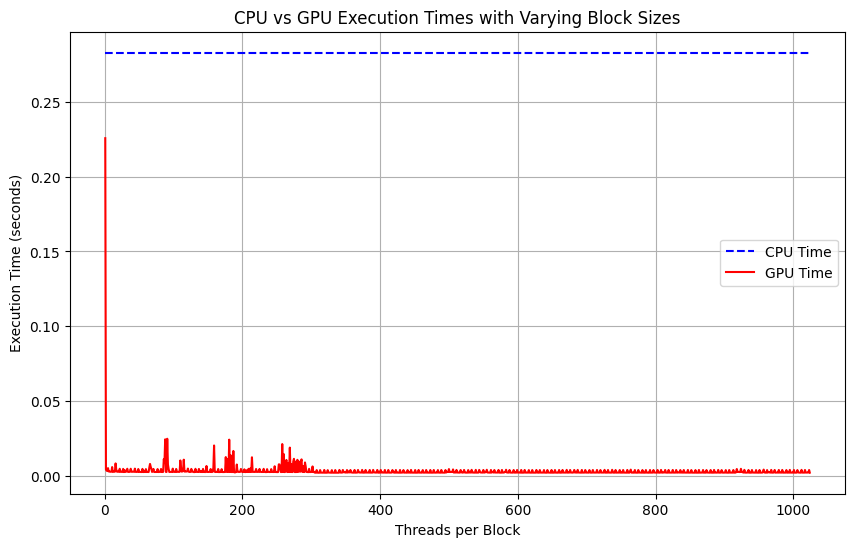

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, njit
import time

def load_image(path):
    return plt.imread(path).astype(np.float32)

def flatten_image(image):
    return image.reshape(-1, 3)

@njit
def to_grayscale_cpu(pixels):
    pixel_count = len(pixels)
    gray_pixels = np.empty(pixel_count)
    for i in range(pixel_count):
        r, g, b = pixels[i]
        gray_pixels[i] = 0.299 * r + 0.587 * g + 0.114 * b
    return gray_pixels

@cuda.jit
def to_grayscale_gpu(pixels, gray_pixels):
    idx = cuda.grid(1)
    if idx < len(pixels):
        r, g, b = pixels[idx]
        gray_pixels[idx] = 0.299 * r + 0.587 * g + 0.114 * b

def perform_gpu_conversion(pixels, blocks_per_grid, threads_per_block):
    pixels_gpu = cuda.to_device(pixels)
    gray_pixels_gpu = cuda.device_array(len(pixels), dtype=np.float32)
    to_grayscale_gpu[blocks_per_grid, threads_per_block](pixels_gpu, gray_pixels_gpu)
    cuda.synchronize()
    return gray_pixels_gpu.copy_to_host()

def measure_time(func, *args):
    start_time = time.time()
    result = func(*args)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def run_benchmark(threads_per_block_values):
    image = load_image('unnamed.jpg')
    pixels = flatten_image(image)

    _, cpu_time = measure_time(to_grayscale_cpu, pixels)

    gpu_times = []
    for threads_per_block in threads_per_block_values:
        blocks_per_grid = (len(pixels) + (threads_per_block - 1)) // threads_per_block
        _, gpu_time = measure_time(perform_gpu_conversion, pixels, blocks_per_grid, threads_per_block)
        gpu_times.append(gpu_time)

    return cpu_time, gpu_times

def plot_times(threads_per_block_values, cpu_time, gpu_times):
    plt.figure(figsize=(10, 6))

    plt.plot(threads_per_block_values, [cpu_time] * len(threads_per_block_values), label='CPU Time', linestyle='--', color='blue')
    plt.plot(threads_per_block_values, gpu_times, label='GPU Time', color='red')

    plt.title('CPU vs GPU Execution Times with Varying Block Sizes')
    plt.xlabel('Threads per Block')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

threads_per_block_values = np.arange(1, 1025)
cpu_time, gpu_times = run_benchmark(threads_per_block_values)
plot_times(threads_per_block_values, cpu_time, gpu_times)